In [37]:
import os
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional, Input, BatchNormalization, GlobalAveragePooling1D, Activation

import tensorflow.keras

from keras_self_attention import SeqSelfAttention

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import mean, std

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix

In [38]:
tdf = pd.read_csv('C:/Users/GC/freq_2.csv')

In [39]:
fdf = pd.read_csv('C:/Users/GC/time_2.csv')

In [40]:
tdf.columns

Index(['FIA_F', 'FIA_V', 'FIA_L', 'FIL_F', 'FIL_V', 'FIL_L', 'FIT_F', 'FIT_V',
       'FIT_L', 'PA_F', 'PA_V', 'PA_L', 'PL_F', 'PL_V', 'PL_L', 'PT_F', 'PT_V',
       'PT_L', 'EN_A_F', 'EN_A_V', 'EN_A_L', 'EN_L_F', 'EN_L_V', 'EN_L_L',
       'EN_T_F', 'EN_T_V', 'EN_T_L', 'ENt_A_F', 'ENt_A_V', 'ENt_A_L',
       'ENt_L_F', 'ENt_L_V', 'ENt_L_L', 'ENt_T_F', 'ENt_T_V', 'ENt_T_L',
       'peak_A_F', 'peak_A_V', 'peak_A_L', 'peak_L_F', 'peak_L_V', 'peak_L_L',
       'peak_T_F', 'peak_T_V', 'peak_T_L'],
      dtype='object')

In [41]:
fdf.columns

Index(['0', 'mean_A_F', 'var_A_F', 'std_A_F', 'rms_A_F', 'mav_A_F', 'mean_A_V',
       'var_A_V', 'std_A_V', 'rms_A_V', 'mav_A_V', 'mean_A_L', 'var_A_L',
       'std_A_L', 'rms_A_L', 'mav_A_L', 'mean_L_F', 'var_L_F', 'std_L_F',
       'rms_L_F', 'mav_L_F', 'mean_L_V', 'var_L_V', 'std_L_V', 'rms_L_V',
       'mav_L_V', 'mean_L_L', 'var_L_L', 'std_L_L', 'rms_L_L', 'mav_L_L',
       'mean_T_F', 'var_T_F', 'std_T_F', 'rms_T_F', 'mav_T_F', 'mean_T_V',
       'var_T_V', 'std_T_V', 'rms_T_V', 'mav_T_V', 'mean_T_L', 'var_T_L',
       'std_T_L', 'rms_T_L', 'mav_T_L'],
      dtype='object')

In [42]:
df = pd.concat([tdf,fdf],axis = 1)

In [43]:
df.rename(columns={'0': 'Action'}, inplace=True)
df.columns

Index(['FIA_F', 'FIA_V', 'FIA_L', 'FIL_F', 'FIL_V', 'FIL_L', 'FIT_F', 'FIT_V',
       'FIT_L', 'PA_F', 'PA_V', 'PA_L', 'PL_F', 'PL_V', 'PL_L', 'PT_F', 'PT_V',
       'PT_L', 'EN_A_F', 'EN_A_V', 'EN_A_L', 'EN_L_F', 'EN_L_V', 'EN_L_L',
       'EN_T_F', 'EN_T_V', 'EN_T_L', 'ENt_A_F', 'ENt_A_V', 'ENt_A_L',
       'ENt_L_F', 'ENt_L_V', 'ENt_L_L', 'ENt_T_F', 'ENt_T_V', 'ENt_T_L',
       'peak_A_F', 'peak_A_V', 'peak_A_L', 'peak_L_F', 'peak_L_V', 'peak_L_L',
       'peak_T_F', 'peak_T_V', 'peak_T_L', 'Action', 'mean_A_F', 'var_A_F',
       'std_A_F', 'rms_A_F', 'mav_A_F', 'mean_A_V', 'var_A_V', 'std_A_V',
       'rms_A_V', 'mav_A_V', 'mean_A_L', 'var_A_L', 'std_A_L', 'rms_A_L',
       'mav_A_L', 'mean_L_F', 'var_L_F', 'std_L_F', 'rms_L_F', 'mav_L_F',
       'mean_L_V', 'var_L_V', 'std_L_V', 'rms_L_V', 'mav_L_V', 'mean_L_L',
       'var_L_L', 'std_L_L', 'rms_L_L', 'mav_L_L', 'mean_T_F', 'var_T_F',
       'std_T_F', 'rms_T_F', 'mav_T_F', 'mean_T_V', 'var_T_V', 'std_T_V',
       'rms_T_V', 'mav_

In [44]:
# 'Action' 칼럼을 제외한 모든 칼럼에서 0이거나 NaN이 포함된 행을 삭제
columns_to_check = df.columns.difference(['Action'])
df_filtered = df[~(df[columns_to_check] == 0).any(axis=1) & ~(df[columns_to_check].isnull()).any(axis=1)]

df_filtered

,FIA_F,FIA_V,FIA_L,FIL_F,FIL_V,FIL_L,FIT_F,FIT_V,FIT_L,PA_F,...,mean_T_V,var_T_V,std_T_V,rms_T_V,mav_T_V,mean_T_L,var_T_L,std_T_L,rms_T_L,mav_T_L
0,0.255604,0.201880,0.268956,0.215104,0.202261,0.350273,4.642603,0.198401,0.221112,2.419689e+04,...,1015.500000,84.500000,9.192388,1015.541604,1015.500000,-75.828125,110.579834,10.515695,76.553801,75.828125
1,0.221468,0.202177,0.206564,0.209339,0.198753,0.330445,0.771721,0.196140,0.259787,2.197548e+04,...,1012.625000,85.171875,9.228861,1012.667054,1012.625000,-79.406250,121.459961,11.020887,80.167403,79.406250
2,0.366882,0.197780,0.221398,0.905006,0.196448,0.541888,4.203141,0.199720,0.269303,2.692547e+04,...,1013.968750,148.217773,12.174472,1014.041835,1013.968750,-78.750000,170.500000,13.057565,79.825200,78.750000
3,0.236479,0.195585,0.190686,0.245126,0.196283,0.207387,1.918471,0.201184,0.264178,3.892167e+04,...,1013.734375,102.570068,10.127688,1013.784964,1013.734375,-68.000000,182.500000,13.509256,69.328926,68.000000
4,0.200074,0.199114,0.281368,0.388780,0.195081,0.722202,0.377567,0.205098,0.222422,1.008114e+05,...,1017.734375,130.101318,11.406196,1017.798290,1017.734375,-50.609375,675.331787,25.987147,56.891481,50.890625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17242,1.415763,0.339035,1.102846,1.784223,0.201830,0.889792,0.207931,0.251857,1.299440,1.119138e+07,...,995.187500,13073.402344,114.338980,1001.734277,995.187500,115.312500,4171.496094,64.587120,132.168335,117.718750
17243,3.842503,0.478943,3.130317,1.800563,0.138389,1.697710,1.136340,0.219919,2.217932,1.076938e+07,...,1001.328125,7914.001709,88.960675,1005.272110,1001.328125,94.687500,3749.964844,61.236957,112.763857,96.750000
17244,8.706340,0.825687,14.584485,2.404151,0.291611,1.465685,1.399177,0.304837,1.410650,5.139957e+06,...,993.843750,7477.413086,86.472036,997.598523,993.843750,91.750000,3386.000000,58.189346,108.646502,96.500000
17245,9.477554,2.104247,7.352573,4.585981,0.276006,2.614604,2.867446,0.204642,1.791834,6.497664e+06,...,997.781250,7689.389648,87.689165,1001.627083,997.781250,112.687500,5700.277344,75.500181,135.641992,112.968750


In [45]:
df_filtered['Action'].value_counts()

Action
0    15103
1     1616
Name: count, dtype: int64

df = df_filtered[df_filtered['Action'] != 2]

In [46]:
NUM = 0

count_0 = (df['Action'] == 0).sum()
count_1 = (df['Action'] == 1).sum()

NUM = min(count_1, count_0)
NUM

1617

In [47]:
Normal = df[df['Action'] == 1].head(NUM).copy()
FoG = df[df['Action'] == 0].head(NUM).copy()

In [48]:
data = pd.DataFrame()
data = pd.concat([Normal, FoG])

In [49]:
df = data.copy()

In [50]:
df['Action'].value_counts()

Action
1    1617
0    1617
Name: count, dtype: int64

In [51]:
df.columns

Index(['FIA_F', 'FIA_V', 'FIA_L', 'FIL_F', 'FIL_V', 'FIL_L', 'FIT_F', 'FIT_V',
       'FIT_L', 'PA_F', 'PA_V', 'PA_L', 'PL_F', 'PL_V', 'PL_L', 'PT_F', 'PT_V',
       'PT_L', 'EN_A_F', 'EN_A_V', 'EN_A_L', 'EN_L_F', 'EN_L_V', 'EN_L_L',
       'EN_T_F', 'EN_T_V', 'EN_T_L', 'ENt_A_F', 'ENt_A_V', 'ENt_A_L',
       'ENt_L_F', 'ENt_L_V', 'ENt_L_L', 'ENt_T_F', 'ENt_T_V', 'ENt_T_L',
       'peak_A_F', 'peak_A_V', 'peak_A_L', 'peak_L_F', 'peak_L_V', 'peak_L_L',
       'peak_T_F', 'peak_T_V', 'peak_T_L', 'Action', 'mean_A_F', 'var_A_F',
       'std_A_F', 'rms_A_F', 'mav_A_F', 'mean_A_V', 'var_A_V', 'std_A_V',
       'rms_A_V', 'mav_A_V', 'mean_A_L', 'var_A_L', 'std_A_L', 'rms_A_L',
       'mav_A_L', 'mean_L_F', 'var_L_F', 'std_L_F', 'rms_L_F', 'mav_L_F',
       'mean_L_V', 'var_L_V', 'std_L_V', 'rms_L_V', 'mav_L_V', 'mean_L_L',
       'var_L_L', 'std_L_L', 'rms_L_L', 'mav_L_L', 'mean_T_F', 'var_T_F',
       'std_T_F', 'rms_T_F', 'mav_T_F', 'mean_T_V', 'var_T_V', 'std_T_V',
       'rms_T_V', 'mav_

In [52]:
df_corr=df.corr()
matrix=df_corr.to_numpy()
target_row = matrix[-1, :]
indices_above_threshold = np.where(target_row >= 0.25)[0]

column_names = df.columns.tolist()
list0 = df.columns[indices_above_threshold].tolist()
df_total =df[list0]

#상관 관계 행렬
df_corr=df_total.corr()

#히트맵
plt.figure(figsize=(20,20))
sns.set(font_scale=3)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()
sns.set(font_scale=1)

In [53]:
df_total.columns

Index(['PT_L', 'EN_L_F', 'EN_L_L', 'EN_T_F', 'EN_T_L', 'ENt_L_F', 'ENt_T_F',
       'ENt_T_V', 'mean_A_L', 'mean_L_F', 'rms_L_F', 'mav_L_F', 'mean_L_L',
       'rms_L_L', 'mav_L_L', 'mean_T_F', 'rms_T_F', 'mav_T_F', 'mean_T_L',
       'rms_T_L', 'mav_T_L'],
      dtype='object')

In [54]:
df_e = df[['PT_L', 'EN_L_F', 'EN_L_L', 'EN_T_F', 'EN_T_L', 'ENt_L_F', 'ENt_T_F',
       'ENt_T_V', 'mean_A_L', 'mean_L_F', 'rms_L_F', 'mav_L_F', 'mean_L_L',
       'rms_L_L', 'mav_L_L', 'mean_T_F', 'rms_T_F', 'mav_T_F', 'mean_T_L',
       'rms_T_L', 'mav_T_L', 'Action']]

In [55]:
#df_e.dropna(inplace=True)
#df_e['Action'].value_counts()

In [56]:
y = df_e['Action']
X = df_e.drop(columns=['Action'], axis=1)

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1617, 21), (1617, 21), (1617,), (1617,))

In [59]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [60]:
timestamp = 5

# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, timestamp)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, timestamp)
print(X_test.shape, y_test.shape)

(1613, 5, 21) (1613,)
(1613, 5, 21) (1613,)


In [61]:
trainy_one_hot = to_categorical(y_train)
testy_one_hot = to_categorical(y_test)

In [74]:
from tensorflow.keras.layers import add

#DENSE_NUM = 6
#num_filters = 2
#LSTM_units = 8
#kernel_size = 3
#strides = 1

DENSE_NUM = 6
num_filters = 2
LSTM_units = 8
kernel_size = 3
strides = 1

def Conv_1D_Block(x, model_width, kernel_size , strides_size):
    x = tf.keras.layers.Conv1D(model_width, kernel_size, strides=strides, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def dense_block(x, num_filters, num_layers, bottleneck=True):
    for _ in range(num_layers):
        cb = Conv_1D_Block(x, num_filters, kernel_size , strides)
        x = tf.keras.layers.concatenate([x, cb], axis=-1)
    return x

def transition_block(x, num_filters):
    x = Conv_1D_Block(x, num_filters, 1, 2)
    x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding="same")(x)
    return x

def DenseNet(length, num_channel, num_filters):
    inputs = tf.keras.Input((length, num_channel))    
    B = layers.Bidirectional(layers.LSTM(LSTM_units, return_sequences = True, activation = "relu"))(inputs) 

    
    x = dense_block(B, num_filters * 2, DENSE_NUM)
    x = transition_block(x, num_filters)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)    

    Bflat = tf.keras.layers.Flatten()(B)
    out = add([x, Bflat])
    
    flat = tf.keras.layers.Flatten()(out)
    outputs = tf.keras.layers.Dense(2, activation = "softmax")(flat)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Usage Example
length = X_train.shape[1]
num_channel = X_train.shape[2]
model = DenseNet(length, num_channel, num_filters)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: Inputs have incompatible shapes. Received shapes (2,) and (80,)

In [ ]:
model.summary()

In [64]:
from keras.layers import concatenate

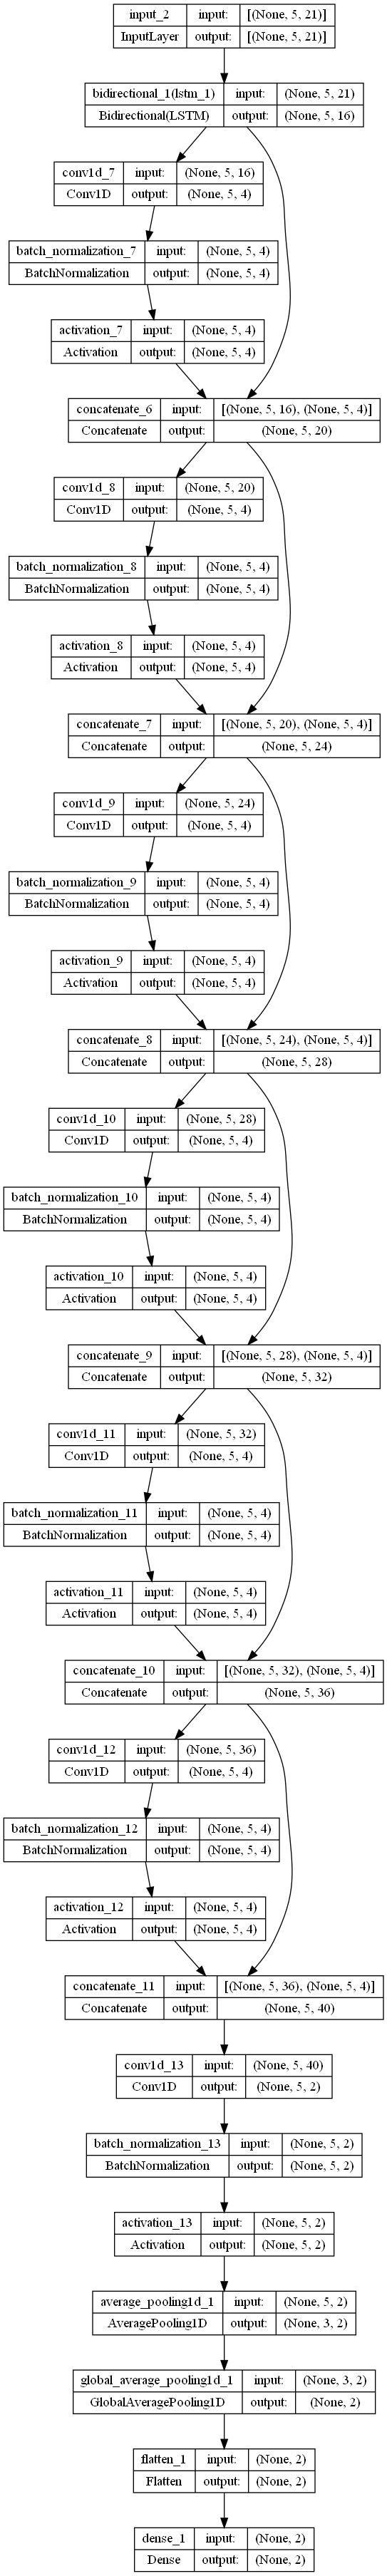

In [65]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [66]:
history = model.fit(X_train, trainy_one_hot, epochs = 30, batch_size = 32, validation_split = 0.1, shuffle = True)

Epoch 1/30
46/46 [==============================] - 6s 15ms/step - loss: 0.6832 - accuracy: 0.6079 - val_loss: 0.6764 - val_accuracy: 0.6605
Epoch 2/30
46/46 [==============================] - 0s 5ms/step - loss: 0.6403 - accuracy: 0.7443 - val_loss: 0.6447 - val_accuracy: 0.6235
Epoch 3/30
46/46 [==============================] - 0s 5ms/step - loss: 0.5989 - accuracy: 0.8663 - val_loss: 0.6043 - val_accuracy: 0.6543
Epoch 4/30
46/46 [==============================] - 0s 5ms/step - loss: 0.5528 - accuracy: 0.9338 - val_loss: 0.5462 - val_accuracy: 0.8025
Epoch 5/30
46/46 [==============================] - 0s 6ms/step - loss: 0.5061 - accuracy: 0.9649 - val_loss: 0.4890 - val_accuracy: 0.9321
Epoch 6/30
46/46 [==============================] - 0s 6ms/step - loss: 0.4617 - accuracy: 0.9711 - val_loss: 0.4317 - val_accuracy: 0.9753
Epoch 7/30
46/46 [==============================] - 0s 5ms/step - loss: 0.4195 - accuracy: 0.9773 - val_loss: 0.3831 - val_accuracy: 0.9753
Epoch 8/30
46/46 [=

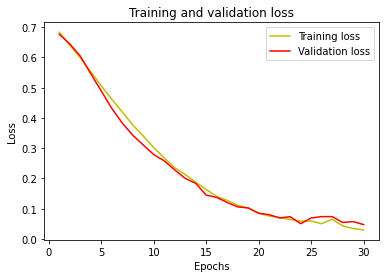

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

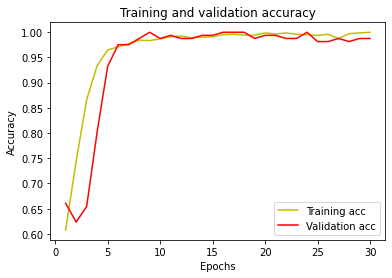

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

51/51 [==============================] - 0s 2ms/step
[[781   7]
 [  6 819]]
Accuracy Score: 0.9919404835709857
F1 Score (Weighted): 0.9919403657927757
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       788
         1.0       0.99      0.99      0.99       825

    accuracy                           0.99      1613
   macro avg       0.99      0.99      0.99      1613
weighted avg       0.99      0.99      0.99      1613



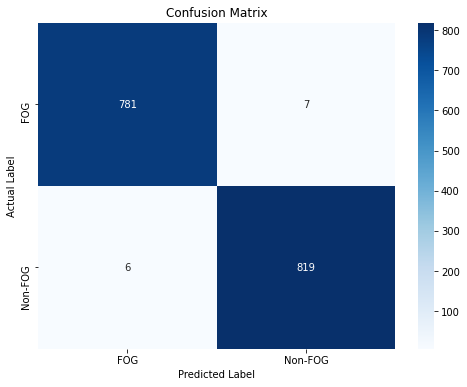

In [69]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming model.predict and X_test are defined elsewhere
predy = model.predict(X_test)
predy = np.argmax(predy, axis=-1)
LABELS = ['FOG', 'Non-FOG']

# Calculate confusion matrix and other metrics
cm = confusion_matrix(y_test, predy)
print(cm)
print("Accuracy Score:", accuracy_score(y_test, predy))
print("F1 Score (Weighted):", f1_score(y_test, predy, average='weighted'))
print(classification_report(y_test, predy))

# Plotting the heatmap
plt.figure(figsize=(8, 6))  # Adjust the size of the figure as needed
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [70]:

def calculate_sensitivity_specificity(y_test, predy):
    # 혼동 행렬 생성
    tn, fp, fn, tp = confusion_matrix(y_test, predy).ravel()

    # Sensitivity (민감도) 계산: TP / (TP + FN)
    sensitivity = tp / (tp + fn)

    # Specificity (특이도) 계산: TN / (TN + FP)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

sensitivity, specificity = calculate_sensitivity_specificity(y_test, predy)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.9927272727272727
Specificity: 0.9911167512690355


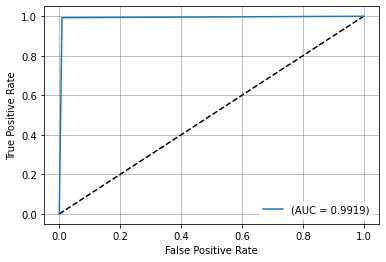

0.9919220119981541

In [71]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predy)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
ax = plt.gca()  # 현재 축 가져오기
ax.set_facecolor('white')  # 플롯 영역의 배경색을 하얗게 설정
for spine in ax.spines.values():
    spine.set_edgecolor('black')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.4f})'.format(auc_keras))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curve')
legend = plt.legend(loc='best', frameon=True)
legend.get_frame().set_color('white')

plt.grid(True, color='gray', linestyle='-', linewidth=0.5)  # 격자선 추가
plt.show()

auc_keras